# Import Libraries

In [18]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import json
import cv2
import matplotlib
import matplotlib.pyplot as plt
import scipy
import warnings
import shutil
import random
import shutil 

from PIL import Image
from tqdm import tqdm
import torchvision.transforms as T
from pprint import pprint
from distutils.dir_util import copy_tree

# Process the dataset

In [3]:
for filename in tqdm(os.listdir('Manga_CycleGAN/manga/train_test')):
    if filename[0] == '.': continue
    file_path = os.path.join('Manga_CycleGAN/manga/train_test',filename)
    print(f'{filename} has {len(os.listdir(file_path))} images.')

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 124.55it/s]

testA has 716 images.
trainB has 2861 images.
testB has 716 images.
trainA has 2861 images.


# Install MMGeneration

In [16]:
!python -m pip install --upgrade pip

     |████████████████████████████████| 2.1 MB 263 kB/s 
  Attempting uninstall: pip
    Found existing installation: pip 20.2.3
    Uninstalling pip-20.2.3:
      Successfully uninstalled pip-20.2.3


In [4]:
from mmcv import collect_env
collect_env()

/Users/leo/anaconda3/lib/python3.11/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/Users/leo/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


{'sys.platform': 'darwin',
 'Python': '3.11.7 | packaged by conda-forge | (main, Dec 23 2023, 14:38:07) [Clang 16.0.6 ]',
 'CUDA available': False,
 'GCC': 'Apple clang version 15.0.0 (clang-1500.3.9.4)',
 'PyTorch': '2.3.0',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 4.2\n  - C++ Version: 201703\n  - clang 14.0.3\n  - LAPACK is enabled (usually provided by MKL)\n  - NNPACK is enabled\n  - CPU capability usage: NO AVX\n  - Build settings: BLAS_INFO=accelerate, BUILD_TYPE=Release, CXX_COMPILER=/Applications/Xcode_14.3.1.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/clang++, CXX_FLAGS= -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -DNDEBUG -DUSE_KINETO -DLIBKINETO_NOCUPTI -DLIBKINETO_NOROCTRACER -DUSE_PYTORCH_QNNPACK -DUSE_XNNPACK -DUSE_PYTORCH_METAL_EXPORT -DSYMBOLICATE_MOBILE_DEBUG_HANDLE -DUSE_COREML_DELEGATE -O2 -fPIC -Wall -Wextra -Werror=return-type -Werror=non-virtual-dtor -Werror=braced-scalar-init -Werror=range-loop-construct -Werror=bool-op

In [5]:
# Check MMDetection installation
import mmgen
print(mmgen.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

0.7.3
not available
clang 15.0.0


# Start Inference

In [6]:
%ls

Manga_CycleGAN/
README.md
cyclegan_lsgan_resnet_in_summer2winter_b1x1_250k.py
logs/
manga-colorization-inference.ipynb
mmgeneration/
training_samples/
weight/


shape of grayscale image:  (1600, 2133, 3)


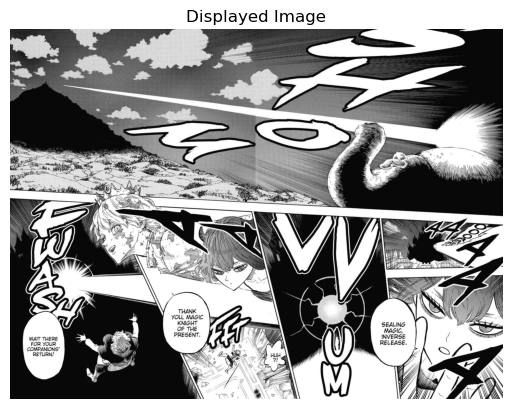

In [7]:
# Load the image
image1 = cv2.imread('Manga_CycleGAN/manga/train_test/testA/blackclover_bw22.png')
print('shape of grayscale image: ',image1.shape)
# OpenCV loads images in BGR format by default. Convert it to RGB format.
image_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Use matplotlib to display the image
plt.imshow(image_rgb)
plt.title('Displayed Image')
plt.axis('off')  # Hide the axis
plt.show()


shape of grayscale image:  (1333, 924, 3)


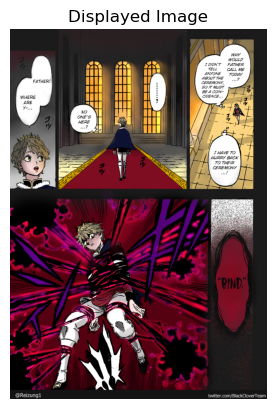

In [8]:
# Load the image
image1 = cv2.imread('Manga_CycleGAN/manga/train_test/testB/blackclover_cl33.png')
print('shape of grayscale image: ',image1.shape)
# OpenCV loads images in BGR format by default. Convert it to RGB format.
image_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Use matplotlib to display the image
plt.imshow(image_rgb)
plt.title('Displayed Image')
plt.axis('off')  # Hide the axis
plt.show()


In [25]:
# from PIL import Image
# import os, sys

# path = ".././train_test/testA/"
# dirs = os.listdir( path )

# def resize():
#     for item in tqdm(dirs, 'resizing images'):
#         if os.path.isfile(path+item):
#             im = Image.open(path+item)
# #             f, e = os.path.splitext(path+item)
#             imResize = im.resize((512,732), Image.ANTIALIAS)
#             imResize.save('.././graysacle4test/' + item)

# resize()

In [9]:
output_dir = 'Manga_CycleGAN/manga/train_test/translated_testA'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [27]:
output_dir

'Manga_CycleGAN/manga/train_test/translated_testA'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

import mmcv
from mmgen.apis import init_model, sample_img2img_model

# Specify the path to model config and checkpoint file
config_file = '/Users/leo/Desktop/Manga-Colorization/cyclegan_lsgan_resnet_in_summer2winter_b1x1_250k.py'
checkpoint_file = '/Users/leo/Desktop/Manga-Colorization/weight/iter_160000.pth'
device = 'cpu'
model = init_model(config_file, checkpoint_file, device=device)


In [77]:
import time
from torchvision.utils import save_image
from torchvision import transforms

In [120]:
time_record = []

for img_name in tqdm(os.listdir('Manga_CycleGAN/manga/train_test/testA')):
    start_time = time.time()

    image_path = os.path.join('Manga_CycleGAN/manga/train_test/testA',img_name)
    translated_image = sample_img2img_model(model, image_path, target_domain='colored')
    translated_image = translated_image[0, [2, 1, 0]] # [3, 368, 256]
    #print(translated_image.shape)
    #new_image = (translated_image + 1) / 2 * 255
    end_time = time.time()

    resize = transforms.Resize((299,299))
    translated_image = resize(translated_image)
    print('shape of image tensor: ',translated_image.shape)

    time_record.append(end_time-start_time)
   
    # Save the image
    #output_path = os.path.join('Manga_CycleGAN/manga/train_test/translated_testA', img_name)
    output_path = os.path.join('Manga_CycleGAN/manga/eval/transform_testA', img_name)
    save_image(translated_image,output_path)



  0%|          | 1/716 [00:00<10:34,  1.13it/s]

torch.Size([3, 368, 256])


  0%|          | 2/716 [00:01<09:04,  1.31it/s]

torch.Size([3, 368, 256])


  0%|          | 3/716 [00:02<08:02,  1.48it/s]

torch.Size([3, 368, 256])


  1%|          | 4/716 [00:02<07:33,  1.57it/s]

torch.Size([3, 368, 256])


  1%|          | 5/716 [00:03<07:13,  1.64it/s]

torch.Size([3, 368, 256])


  1%|          | 5/716 [00:03<08:19,  1.42it/s]


KeyboardInterrupt: 

In [80]:
print(f'Average Inference time {np.mean(time_record)}, +- {np.std(time_record)} seconds.')

Average Inference time 0.5999599918306873, +- 0.09402672513985443 seconds.


### Show a couple of demo image

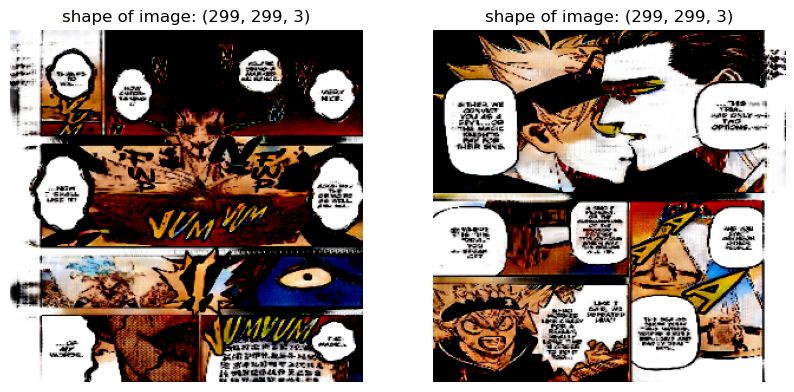

In [83]:
# Load the image
image1 = cv2.imread('Manga_CycleGAN/manga/eval/transform_testA/blackclover_bw5.png')
image2 = cv2.imread('Manga_CycleGAN/manga/eval/transform_testA/blackclover_bw197.png')

# OpenCV loads images in BGR format by default. Convert it to RGB format.
image_rgb1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image_rgb2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
# Use matplotlib to display the image
plt.figure(figsize=(10, 5))  # Width, height in inches

# Display the first image
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.imshow(image_rgb1)
plt.title(f'shape of image: {image1.shape}')
plt.axis('off')  # Hide the axis

# Display the second image
plt.subplot(1, 2, 2)
plt.imshow(image_rgb2)
plt.title(f'shape of image: {image2.shape}')
plt.axis('off')  # Hide the axis

# Show both images
plt.show()


In [86]:
type(image2)

numpy.ndarray

## FID Eval

### First we need to reshape both images in translated_testA and testB to (299,299), and normalize to [-1,1]

In [91]:
import torch

In [109]:
sample = cv2.imread('Manga_CycleGAN/manga/train_test/testB/blackclover_cl31.png')
print(sample.shape)
print(type(sample))

(1024, 768, 3)
<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


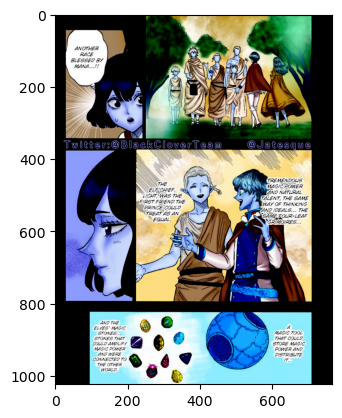

In [115]:
trs = (sample/255)*2-1
plt.imshow(trs)

In [118]:
trs.max()

1.0

In [110]:
torch.tensor(sample).permute(2,0,1).shape

torch.Size([3, 1024, 768])

In [122]:
for img_name in tqdm(os.listdir('Manga_CycleGAN/manga/train_test/testB')):
    img_path = os.path.join('Manga_CycleGAN/manga/train_test/testB',img_name)

    image = cv2.imread(img_path) # 1024 x 768 x 3
    image = torch.tensor(image)
    transformed_image = image.permute(2, 0, 1) # 3 x 1024 x 768
    transformed_image = (transformed_image/255)*2-1
    resize = transforms.Resize((299,299))
    translated_image = resize(transformed_image) # 3 x 299 x 299

    #print(translated_image.shape)

    # Save the image
    output_path = os.path.join('Manga_CycleGAN/manga/eval/transform_testB', img_name)
    save_image(translated_image,output_path)

    

100%|██████████| 716/716 [00:23<00:00, 30.82it/s]


In [124]:
print('transform_testB (ground truth):', len(os.listdir('Manga_CycleGAN/manga/eval/transform_testB')))
print('transform_testA (Generated Img):', len(os.listdir('Manga_CycleGAN/manga/eval/transform_testA')))

transform_testB (ground truth): 716
transform_testA (Generated Img): 716
